# Transfert Learning ResNet 101

In [20]:
import tensorflow as tf
import keras
from keras import Model
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
# Early stopping & checkpointing the best model in
#../working dir & restoring that as our model for prediction
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

In [21]:
ResNet_101 = tf.keras.applications.ResNet101(
    include_top=False,
    weights="imagenet",
    pooling="avg"
)

In [22]:
NUMB_CLASSES = 2
DENSE_LAYER_ACTIVATION = 'softmax'
# Transfert Learning 
model = tf.keras.Sequential()
model.add(ResNet_101)
model.add(Dense(NUMB_CLASSES, activation = DENSE_LAYER_ACTIVATION))
model.layers[0].trainable = False

In [23]:
# Optimizer sgd il y a aussi adam ..
sgd = tf.keras.optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
OBJECTIVE_FUNCTION = 'categorical_crossentropy' # loss il y a ausi mean_squared_error ...
LOSS_METRICS = ['accuracy']

model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [24]:
# Prepare Keras Data Generators
from keras.applications.resnet50 import preprocess_input

image_size = 224
BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 100

data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = data_generator.flow_from_directory(
        'C:/Users/lenovo/Desktop/DONNEES/DATA/train',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
        'C:/Users/lenovo/Desktop/DONNEES/DATA/validation',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='categorical') 

Found 3629 images belonging to 2 classes.
Found 1555 images belonging to 2 classes.


In [25]:
(BATCH_SIZE_TRAINING, len(train_generator), BATCH_SIZE_VALIDATION, len(validation_generator))

(100, 37, 100, 16)

In [26]:
EARLY_STOP_PATIENCE = 3

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = 'C:/Users/lenovo/Desktop/DONNEES/best_101.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [28]:
NUM_EPOCHS = 10
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer, cb_early_stopper]
)

Epoch 1/10
10/10 [==============================] - 512s 51s/step - loss: 0.1664 - accuracy: 0.9420 - val_loss: 0.1661 - val_accuracy: 0.9390
Epoch 2/10
10/10 [==============================] - 411s 41s/step - loss: 0.1479 - accuracy: 0.9490 - val_loss: 0.1821 - val_accuracy: 0.9400
Epoch 3/10
10/10 [==============================] - 394s 39s/step - loss: 0.1243 - accuracy: 0.9580 - val_loss: 0.1538 - val_accuracy: 0.9400
Epoch 4/10
10/10 [==============================] - 417s 42s/step - loss: 0.1035 - accuracy: 0.9666 - val_loss: 0.1609 - val_accuracy: 0.9420
Epoch 5/10
10/10 [==============================] - 385s 38s/step - loss: 0.1367 - accuracy: 0.9569 - val_loss: 0.1650 - val_accuracy: 0.9430
Epoch 6/10
10/10 [==============================] - 429s 43s/step - loss: 0.0842 - accuracy: 0.9690 - val_loss: 0.1388 - val_accuracy: 0.9560
Epoch 7/10
10/10 [==============================] - 445s 44s/step - loss: 0.0933 - accuracy: 0.9699 - val_loss: 0.1516 - val_accuracy: 0.9480
Epoch 

In [29]:
model.load_weights("C:/Users/lenovo/Desktop/DONNEES/best_101.hdf5")

In [30]:
print(fit_history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


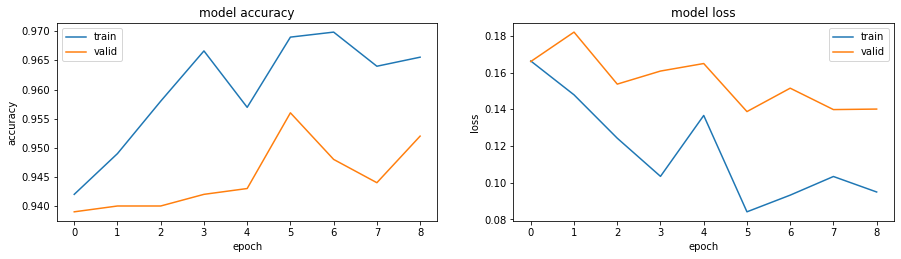

In [31]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['accuracy'])  
plt.plot(fit_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [32]:
BATCH_SIZE_TESTING = 1

test_generator = data_generator.flow_from_directory(
    directory = 'C:/Users/lenovo/Desktop/DONNEES/DATA/test',
    target_size = (image_size, image_size),
    batch_size = BATCH_SIZE_TESTING,
    class_mode = None,
    shuffle = False,
    seed = 123
)

Found 2222 images belonging to 2 classes.


In [33]:
test_generator.reset()

pred = model.predict_generator(test_generator, steps = len(test_generator), verbose = 1)

predicted_class_indices = np.argmax(pred, axis = 1)

Instructions for updating:
Please use Model.predict, which supports generators.
2222/2222 [==============================] - 844s 380ms/step


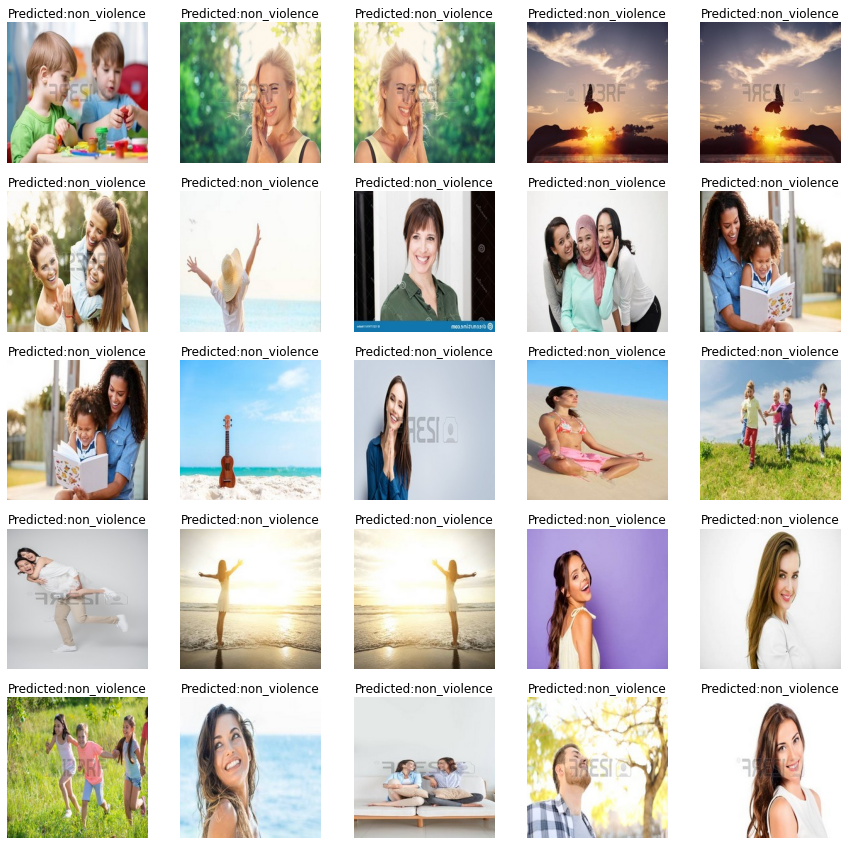

In [34]:
TEST_DIR = 'C:/Users/lenovo/Desktop/DONNEES/DATA/test'
f, ax = plt.subplots(5, 5, figsize = (15, 15))

for i in range(0,25):
    imgBGR = cv2.imread(TEST_DIR +"/"+ test_generator.filenames[i])
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
    
    # a if condition else b
    predicted_class = "violence" if predicted_class_indices[i] else "non_violence"

    ax[i//5, i%5].imshow(imgRGB)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Predicted:{}".format(predicted_class))    

plt.show()


In [91]:
print(predicted_class_indices)
print ("")

[0 0 0 ... 1 1 1]


In [92]:
test_generator.filenames

['non_violence\\1000.jpg',
 'non_violence\\1001.jpg',
 'non_violence\\1002.jpg',
 'non_violence\\1005.jpg',
 'non_violence\\1006.jpg',
 'non_violence\\1009.jpg',
 'non_violence\\1013.jpg',
 'non_violence\\1020.jpg',
 'non_violence\\1021.jpg',
 'non_violence\\1027.jpg',
 'non_violence\\1028.jpg',
 'non_violence\\1029.jpg',
 'non_violence\\1034.jpg',
 'non_violence\\1037.jpg',
 'non_violence\\104.jpg',
 'non_violence\\1044.jpg',
 'non_violence\\1045.jpg',
 'non_violence\\1046.jpg',
 'non_violence\\1050.jpg',
 'non_violence\\1058.jpg',
 'non_violence\\1071.jpg',
 'non_violence\\1074.jpg',
 'non_violence\\1076.jpg',
 'non_violence\\1078.jpg',
 'non_violence\\1082.jpg',
 'non_violence\\1083.jpg',
 'non_violence\\1084.jpg',
 'non_violence\\1087.jpg',
 'non_violence\\109.jpg',
 'non_violence\\1090.jpg',
 'non_violence\\1092.jpg',
 'non_violence\\1097.jpg',
 'non_violence\\1106.jpg',
 'non_violence\\1116.jpg',
 'non_violence\\1117.jpg',
 'non_violence\\1118.jpg',
 'non_violence\\1119.jpg',
 'n

In [74]:
test_result = []
for i in range(len(test_generator.filenames)):
    if test_generator.filenames[i].find("non_violence") != -1:
        test_result.append(0)
    else:
        test_result.append(1)


In [75]:
# Taux d'erreur comparaison entre le resultat predit et les labels 
Errors = 0
for i in range(len(test_result)):
    if(test_result[i] != predicted_class_indices[i]):
        Errors = Errors + 1
Errors_rate = Errors/len(predicted_class_indices)

print("Errors : ",Errors)
print("Errors rate : ", Errors_rate*100,"%")

Errors :  102
Errors rate :  4.59045904590459 %


# ResNet Non Pré-entrainé : 

In [76]:
ResNet_101_V = tf.keras.applications.ResNet101(
    include_top=False,
    pooling="avg"
)

In [78]:
# Transfert Learning 
model_V = tf.keras.Sequential()
model_V.add(ResNet_101_V)
model_V.add(Dense(NUMB_CLASSES, activation = DENSE_LAYER_ACTIVATION))
model_V.layers[0].trainable = False

In [79]:
# Optimizer sgd il y a aussi adam ..
model_V.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [80]:
cb_checkpointer = ModelCheckpoint(filepath = 'C:/Users/lenovo/Desktop/DONNEES/best_101_V.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [81]:
NUM_EPOCHS = 10
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10
fit_history = model_V.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer, cb_early_stopper]
)

Epoch 1/10
10/10 [==============================] - 554s 55s/step - loss: 0.9049 - accuracy: 0.7080 - val_loss: 0.4021 - val_accuracy: 0.8540
Epoch 2/10
10/10 [==============================] - 535s 54s/step - loss: 0.3759 - accuracy: 0.8790 - val_loss: 0.3400 - val_accuracy: 0.8890
Epoch 3/10
10/10 [==============================] - 615s 62s/step - loss: 0.2975 - accuracy: 0.9000 - val_loss: 0.2938 - val_accuracy: 0.8980
Epoch 4/10
10/10 [==============================] - 632s 63s/step - loss: 0.2168 - accuracy: 0.9270 - val_loss: 0.2524 - val_accuracy: 0.9060
Epoch 5/10
10/10 [==============================] - 622s 62s/step - loss: 0.1944 - accuracy: 0.9290 - val_loss: 0.1783 - val_accuracy: 0.9350
Epoch 6/10
10/10 [==============================] - 647s 65s/step - loss: 0.1311 - accuracy: 0.9483 - val_loss: 0.1987 - val_accuracy: 0.9230
Epoch 7/10
10/10 [==============================] - 657s 66s/step - loss: 0.1338 - accuracy: 0.9480 - val_loss: 0.1745 - val_accuracy: 0.9350
Epoch 

In [82]:
model_V.load_weights("C:/Users/lenovo/Desktop/DONNEES/best_101.hdf5")

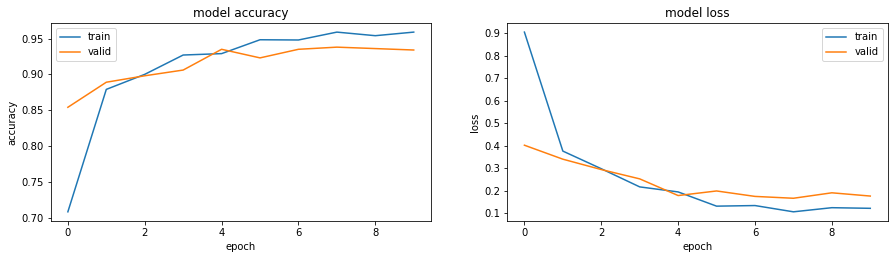

In [83]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['accuracy'])  
plt.plot(fit_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [84]:
test_generator.reset()

pred = model_V.predict_generator(test_generator, steps = len(test_generator), verbose = 1)

predicted_class_indices = np.argmax(pred, axis = 1)

2222/2222 [==============================] - 646s 291ms/step


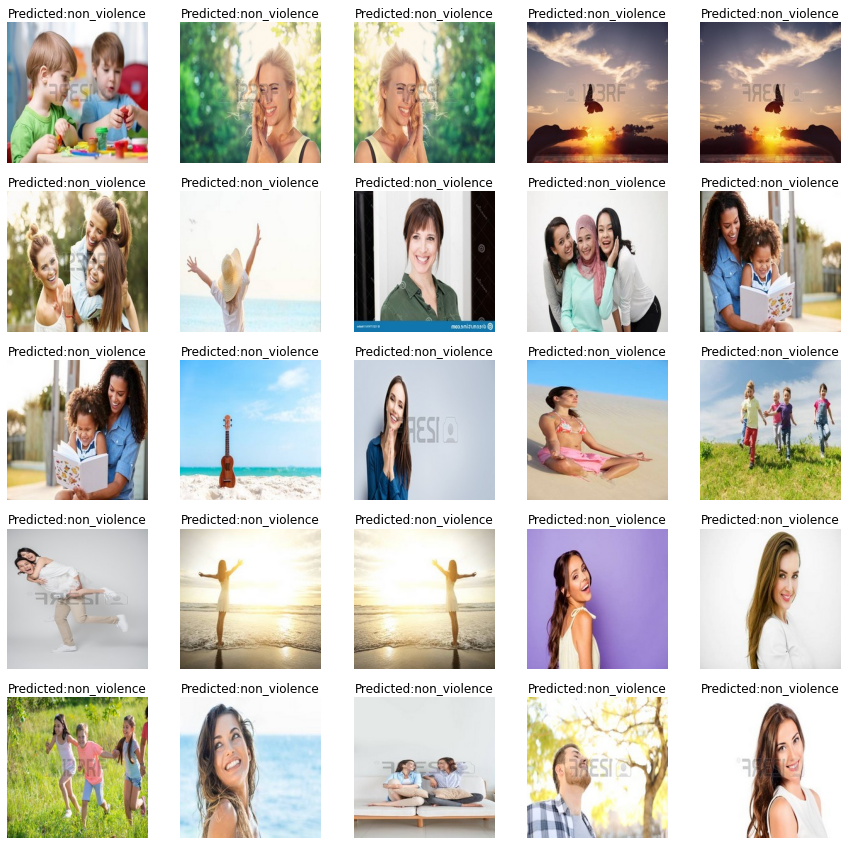

In [85]:
TEST_DIR = 'C:/Users/lenovo/Desktop/DONNEES/DATA/test'
f, ax = plt.subplots(5, 5, figsize = (15, 15))

for i in range(0,25):
    imgBGR = cv2.imread(TEST_DIR +"/"+ test_generator.filenames[i])
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
    
    # a if condition else b
    predicted_class = "violence" if predicted_class_indices[i] else "non_violence"

    ax[i//5, i%5].imshow(imgRGB)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Predicted:{}".format(predicted_class))    

plt.show()


In [86]:
test_result = []
for i in range(len(test_generator.filenames)):
    if test_generator.filenames[i].find("non_violence") != -1:
        test_result.append(0)
    else:
        test_result.append(1)


In [87]:
# Taux d'erreur comparaison entre le resultat predit et les labels 
Errors = 0
for i in range(len(test_result)):
    if(test_result[i] != predicted_class_indices[i]):
        Errors = Errors + 1
Errors_rate = Errors/len(predicted_class_indices)

print("Errors : ",Errors)
print("Errors rate : ", Errors_rate*100,"%")

Errors :  102
Errors rate :  4.59045904590459 %
